In [ ]:
! pip install -U "tensorflow-text==2.13.*"

In [ ]:
! pip install "tf-models-official==2.13.*"

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
# this will be a sentiment analysis model on a movie review
# dataset contains stext of 50000 movie reviews

In [ ]:
# downloading imdb dataset

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
#

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [ ]:
# loading models from tensorflow hub

# tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
# tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_en_uncased_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test =  ['this is such a fabulous movie!']
text_preprocessed = bert_en_uncased_preprocess_model(text_test)

print(text_preprocessed.keys())
print(text_preprocessed['input_word_ids'].shape)
print(text_preprocessed['input_word_ids'][0,:12])

print(text_preprocessed['input_mask'][0,:12])
print(text_preprocessed['input_type_ids'][0,:12])

dict_keys(['input_mask', 'input_type_ids', 'input_word_ids'])
(1, 128)
tf.Tensor([  101  2023  2003  2107  1037 18783  3185   999   102     0     0     0], shape=(12,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0], shape=(12,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0], shape=(12,), dtype=int32)


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)
print(bert_results.keys())
print(bert_results['pooled_output'].shape)
print(bert_results['pooled_output'][0])

print(bert_results['sequence_output'].shape)
print(bert_results['sequence_output'][0])


dict_keys(['encoder_outputs', 'default', 'pooled_output', 'sequence_output'])
(1, 512)
tf.Tensor(
[ 6.59619987e-01  9.92588222e-01 -1.71017766e-01  3.28637153e-01
  3.86225909e-01  9.26083922e-01  9.58266318e-01 -9.69849229e-01
 -8.35187919e-03 -9.77314591e-01  1.98817655e-01 -9.87657905e-01
  9.90509167e-02 -9.99870360e-01  1.28669903e-01  4.97035235e-01
  2.33566105e-01  2.78319150e-01 -2.82273650e-01 -2.12268695e-01
  4.52034920e-02  5.94349578e-03 -9.28778231e-01  1.88010976e-01
  9.92782295e-01  9.91895258e-01 -3.84125650e-01 -1.51553094e-01
  2.37495244e-01  9.50481296e-01  6.03925943e-01 -3.67319249e-02
  3.95105809e-01 -3.85645926e-01  3.87990624e-02 -1.15904950e-01
 -3.04854512e-01 -2.71584094e-01 -6.74950242e-01 -2.41135925e-01
  1.16815390e-02 -6.01176545e-02  5.98969758e-02 -7.13509440e-01
  9.83104482e-02 -1.92615718e-01 -9.97748435e-01  2.62307167e-01
  3.85319263e-01 -3.48027408e-01  9.97411966e-01 -2.88832307e-01
  9.74851191e-01 -5.28070748e-01  2.72048414e-01  1.34134

In [ ]:
# The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

# pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.
# sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.
# encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

In [ ]:
# define our model customized
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string , name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']  # take pooled output
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
#

tf.Tensor([[0.79897106]], shape=(1, 1), dtype=float32)


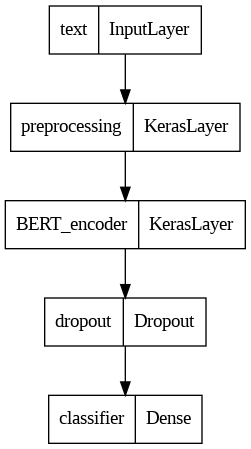

In [ ]:
tf.keras.utils.plot_model(classifier_model)
#

In [ ]:
# Model training
# You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

# Loss function
# Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use losses.BinaryCrossentropy loss function.

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs =5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
#

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
results = classifier_model.fit(x=train_ds,
                             validation_data=val_ds,
                             epochs=epochs)

Epoch 1/5
455/625 [====================>.........] - ETA: 18:35 - loss: 0.5187 - binary_accuracy: 0.7175

KeyboardInterrupt: 

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)